In [109]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn as sk
#from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

データの読み込み

In [61]:
df = pd.read_csv("ks-projects-201801.csv")

In [45]:
display(df.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [40]:
#内容確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


可視化

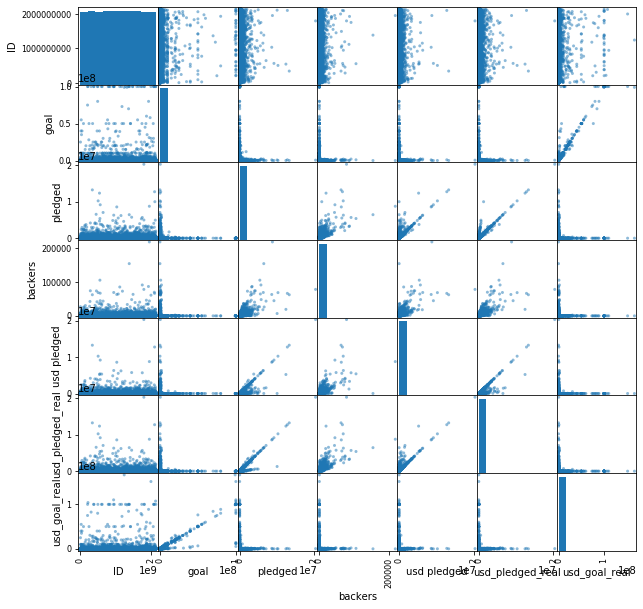

In [41]:
#散布図行列
pd.plotting.scatter_matrix(ks, figsize=(10,10))
plt.show() #時間かかる

In [43]:
#相関係数
df.corr()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
ID,1.000000,0.001679,0.000466,0.000654,-0.000633,-0.000025,0.001854
goal,0.001679,1.000000,0.007358,0.004012,0.005534,0.005104,0.942692
pledged,0.000466,0.007358,1.000000,0.717079,0.857370,0.952843,0.005024
backers,0.000654,0.004012,0.717079,1.000000,0.697426,0.752539,0.004517
usd pledged,-0.000633,0.005534,0.857370,0.697426,1.000000,0.907743,0.006172
usd_pledged_real,-0.000025,0.005104,0.952843,0.752539,0.907743,1.000000,0.005596
usd_goal_real,0.001854,0.942692,0.005024,0.004517,0.006172,0.005596,1.000000


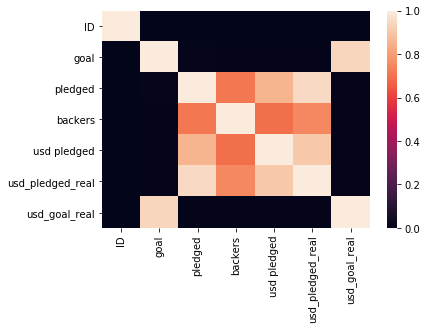

In [44]:
sns.heatmap(df.corr())
plt.show()

前処理<br>
・不要なカラム削除<br>
・launchedからdeadlineを引いて期間を作成<br>
・stateのsussessful,failed以外は頻度を見て少なければ除外<br>
・カテゴリカル変数に変換<br>

In [62]:
# 不要なカラムを削除
# pledged, backers : 達成後の指標のため
# currency, goal : usd_goal_realを使う
rm_col = ['ID','name','currency','goal','backers','pledged','usd pledged','usd_pledged_real']
df_rmcol=df.drop(rm_col, axis=1)

df_rmcol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   category       378661 non-null  object 
 1   main_category  378661 non-null  object 
 2   deadline       378661 non-null  object 
 3   launched       378661 non-null  object 
 4   state          378661 non-null  object 
 5   country        378661 non-null  object 
 6   usd_goal_real  378661 non-null  float64
dtypes: float64(1), object(6)
memory usage: 20.2+ MB


In [70]:
# sateについて
df_rmcol.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [80]:
#KaggleのData Explorerでも見れるが、
#全体の12%と少々大きい気もするが、
#母数が13万件と予測に十分そうなので除外する
df_state = df_rmcol[ (df_rmcol['state'] == 'successful') | (df_rmcol['state'] == 'failed') ]
df_state.state.value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

In [82]:
#期間
#日時の取り扱いが良く分からず

rm_col2 = ['deadline','launched']
df_rmcol2=df_state.drop(rm_col2, axis=1)
df_rmcol2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   category       331675 non-null  object 
 1   main_category  331675 non-null  object 
 2   state          331675 non-null  object 
 3   country        331675 non-null  object 
 4   usd_goal_real  331675 non-null  float64
dtypes: float64(1), object(4)
memory usage: 15.2+ MB


In [106]:
#カテゴリカル変数,boolean

#df_ks_data_all = pd.get_dummies(df_ks_data,  columns=dummy_items ,drop_first = True)
dummy = ['category','main_category','state','country']

df_set = pd.get_dummies(df_rmcol2, columns=dummy)
print(df_set.columns.values.tolist())

['usd_goal_real', 'category_3D Printing', 'category_Academic', 'category_Accessories', 'category_Action', 'category_Animals', 'category_Animation', 'category_Anthologies', 'category_Apparel', 'category_Apps', 'category_Architecture', 'category_Art', 'category_Art Books', 'category_Audio', 'category_Bacon', 'category_Blues', 'category_Calendars', 'category_Camera Equipment', 'category_Candles', 'category_Ceramics', "category_Children's Books", 'category_Childrenswear', 'category_Chiptune', 'category_Civic Design', 'category_Classical Music', 'category_Comedy', 'category_Comic Books', 'category_Comics', 'category_Community Gardens', 'category_Conceptual Art', 'category_Cookbooks', 'category_Country & Folk', 'category_Couture', 'category_Crafts', 'category_Crochet', 'category_DIY', 'category_DIY Electronics', 'category_Dance', 'category_Design', 'category_Digital Art', 'category_Documentary', 'category_Drama', 'category_Drinks', 'category_Electronic Music', 'category_Embroidery', 'categor

In [107]:
#Scikit-learnでロジスティック回帰
df_set2=df_set.drop('state_failed', axis=1)
y = df_set2['state_successful'].values
x = df_set2.drop('state_successful', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(x, y)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='none',
              power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [110]:
# ラベルを予測
y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 59.612%
適合率（Precision） = 59.612%
再現率（Recall） = 99.999%
F1値（F1-score） = 74.696%


In [113]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['真 Goal', '真 NoGoal'], 
                        columns=['予測 Goal', '予測 NoGoal'])
conf_mat

,予測 Goal,予測 NoGoal
真 Goal,197717,2
真 NoGoal,133955,1
